In [ ]:
#Feature Description
"""
Ph: pH of 1. water (0 to 14).
Hardness: Capacity of water to precipitate soap in mg/L.
Solids: Total dissolved solids in ppm.
Chloramines: Amount of Chloramines in ppm.
Sulfate: Amount of Sulfates dissolved in mg/L.
Conductivity: Electrical conductivity of water in μS/cm.
Organic_carbon: Amount of organic carbon in ppm.
Trihalomethanes: Amount of Trihalomethanes in μg/L.
Turbidity: Measure of light emiting property of water in NTU.
Potability: Indicates if water is safe for human consumption.Potable(1),Not potable(0))
"""

'\nPh: pH of 1. water (0 to 14).\nHardness: Capacity of water to precipitate soap in mg/L.\nSolids: Total dissolved solids in ppm.\nChloramines: Amount of Chloramines in ppm.\nSulfate: Amount of Sulfates dissolved in mg/L.\nConductivity: Electrical conductivity of water in μS/cm.\nOrganic_carbon: Amount of organic carbon in ppm.\nTrihalomethanes: Amount of Trihalomethanes in μg/L.\nTurbidity: Measure of light emiting property of water in NTU.\nPotability: Indicates if water is safe for human consumption.Potable(1),Not potable(0))\n'

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn import metrics
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Download dataset from kaggle

! pip install -q kaggle

! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
 
!kaggle datasets download adityakadiwal/water-potability

!unzip /content/water-potability.zip

Archive:  /content/water-potability.zip
  inflating: water_potability.csv    


In [74]:
#Importing The Dataset
df=pd.read_csv('/content/water_potability.csv')
df.head(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [75]:
df.shape

(3276, 10)

In [76]:
df.isna().sum(axis=0)

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [77]:
# Impute Missing Values with Label Matching Mean
for col in ['ph','Trihalomethanes']:
    missing_label_0 = df.query('Potability == 0')[col][df[col].isna()].index
    df.loc[missing_label_0,col] = df.query('Potability == 0')[col][df[col].notna()].mean()

    missing_label_1 = df.query('Potability == 1')[col][df[col].isna()].index
    df.loc[missing_label_1,col] = df.query('Potability == 1')[col][df[col].notna()].mean()
    
df = df.drop(columns="Sulfate")

In [78]:
df.isna().sum(axis=1)

0       0
1       0
2       0
3       0
4       0
       ..
3271    0
3272    0
3273    0
3274    0
3275    0
Length: 3276, dtype: int64

In [79]:
df.dropna(axis=0, inplace=True)

In [80]:
df.isna().sum(axis=0).sum()

0

In [81]:
df.shape

(3276, 9)

In [82]:
df.reset_index(inplace=True)
df.drop('index',inplace=True, axis=1)

In [58]:
#Feature Engineering

In [ ]:
#Using pH readings, we may roughly determine the type of water.
df["Type of Water"] = ""
for i in range(0,len(df)):
    if (df["ph"][i] > 9):
        df["Type of Water"][i] = "Alkaline water"
    elif (df["ph"][i] <= 9 and df["ph"][i] > 8):
        df["Type of Water"][i] = "Bottled waters labeled as alkaline"
    elif (df["ph"][i] <= 8 and df["ph"][i] > 7.5 ):
        df["Type of Water"][i] = "Ocean water"   
    elif(df["ph"][i] == 7.5 ):
        df["Type of Water"][i] = "Tap water"
    elif(df["ph"][i] < 7.5 and df["ph"][i] >=6.5):
        df["Type of Water"][i] = "Common bottled waters"
    elif(df["ph"][i] < 6.5 and df["ph"][i] >=5.5):
        df["Type of Water"][i] = "Distilled reverse osmosis water"
    else:
        df["Type of Water"][i] = "Acidic water"

In [62]:
df.head()

,index,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,Type of Water
0,3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0,Bottled waters labeled as alkaline
1,4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0,Alkaline water
2,5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0,Distilled reverse osmosis water
3,6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0,Alkaline water
4,7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0,Bottled waters labeled as alkaline


In [84]:
# Water hardness is classified by the U.S. Department of Interior and the Water Quality Association as follows:

df["Type of Hardness"] = ""
for i in range(0,len(df)):
    if (df["Hardness"][i] >=0  and df["Hardness"][i] < 17.1):
        df["Type of Hardness"][i] = "Soft"
    elif (df["Hardness"][i] >= 17.1 and df["Hardness"][i] < 60):
        df["Type of Hardness"][i] = "Slightly hard"
    elif (df["Hardness"][i] >= 60 and df["Hardness"][i] < 120 ):
        df["Type of Hardness"][i] = "Moderately hard"   
    elif(df["Hardness"][i] >= 120 and df["Hardness"][i] < 180):
        df["Type of Hardness"][i] = "Hard"
    else:
         df["Type of Hardness"][i] = "Very Hard"

In [85]:
df.head()

,ph,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,Type of Water,Type of Hardness
0,7.085378,204.890455,20791.318981,7.300212,564.308654,10.379783,86.990970,2.963135,0,Common bottled waters,Very Hard
1,3.716080,129.422921,18630.057858,6.635246,592.885359,15.180013,56.329076,4.500656,0,Acidic water,Hard
2,8.099124,224.236259,19909.541732,9.275884,418.606213,16.868637,66.420093,3.055934,0,Bottled waters labeled as alkaline,Very Hard
3,8.316766,214.373394,22018.417441,8.059332,363.266516,18.436524,100.341674,4.628771,0,Bottled waters labeled as alkaline,Very Hard
4,9.092223,181.101509,17978.986339,6.546600,398.410813,11.558279,31.997993,4.075075,0,Alkaline water,Very Hard


In [86]:
# Data Visualization

# Exploratory Data Analysis

d= pd.DataFrame(df['Potability'].value_counts())

fig = px.pie(d,values='Potability',names=['Non-Potable','Potable'],hole=0.45,
             color_discrete_sequence=['#17869E', '#51C4D3'])

fig.add_annotation(text='Potability',x=0.5,y=0.5,showarrow=False,font_size=20)

fig.update_layout(font_family='monospace',
    title=dict(text='Distribution of Target Labels (Drinkability/Potability )',
               x=0.5,y=0.98, font_size=25),
               legend=dict(x=0.425,y=-0.05,orientation='h',traceorder='reversed'))

fig.show()

In [87]:

df

,ph,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,Type of Water,Type of Hardness
0,7.085378,204.890455,20791.318981,7.300212,564.308654,10.379783,86.990970,2.963135,0,Common bottled waters,Very Hard
1,3.716080,129.422921,18630.057858,6.635246,592.885359,15.180013,56.329076,4.500656,0,Acidic water,Hard
2,8.099124,224.236259,19909.541732,9.275884,418.606213,16.868637,66.420093,3.055934,0,Bottled waters labeled as alkaline,Very Hard
3,8.316766,214.373394,22018.417441,8.059332,363.266516,18.436524,100.341674,4.628771,0,Bottled waters labeled as alkaline,Very Hard
4,9.092223,181.101509,17978.986339,6.546600,398.410813,11.558279,31.997993,4.075075,0,Alkaline water,Very Hard
...,...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,526.424171,13.894419,66.687695,4.435821,1,Acidic water,Very Hard
3272,7.808856,193.553212,17329.802160,8.061362,392.449580,19.903225,66.539684,2.798243,1,Ocean water,Very Hard
3273,9.419510,175.762646,33155.578218,7.350233,432.044783,11.039070,69.845400,3.298875,1,Alkaline water,Hard
3274,5.126763,230.603758,11983.869376,6.303357,402.883113,11.168946,77.488213,4.708658,1,Acidic water,Very Hard


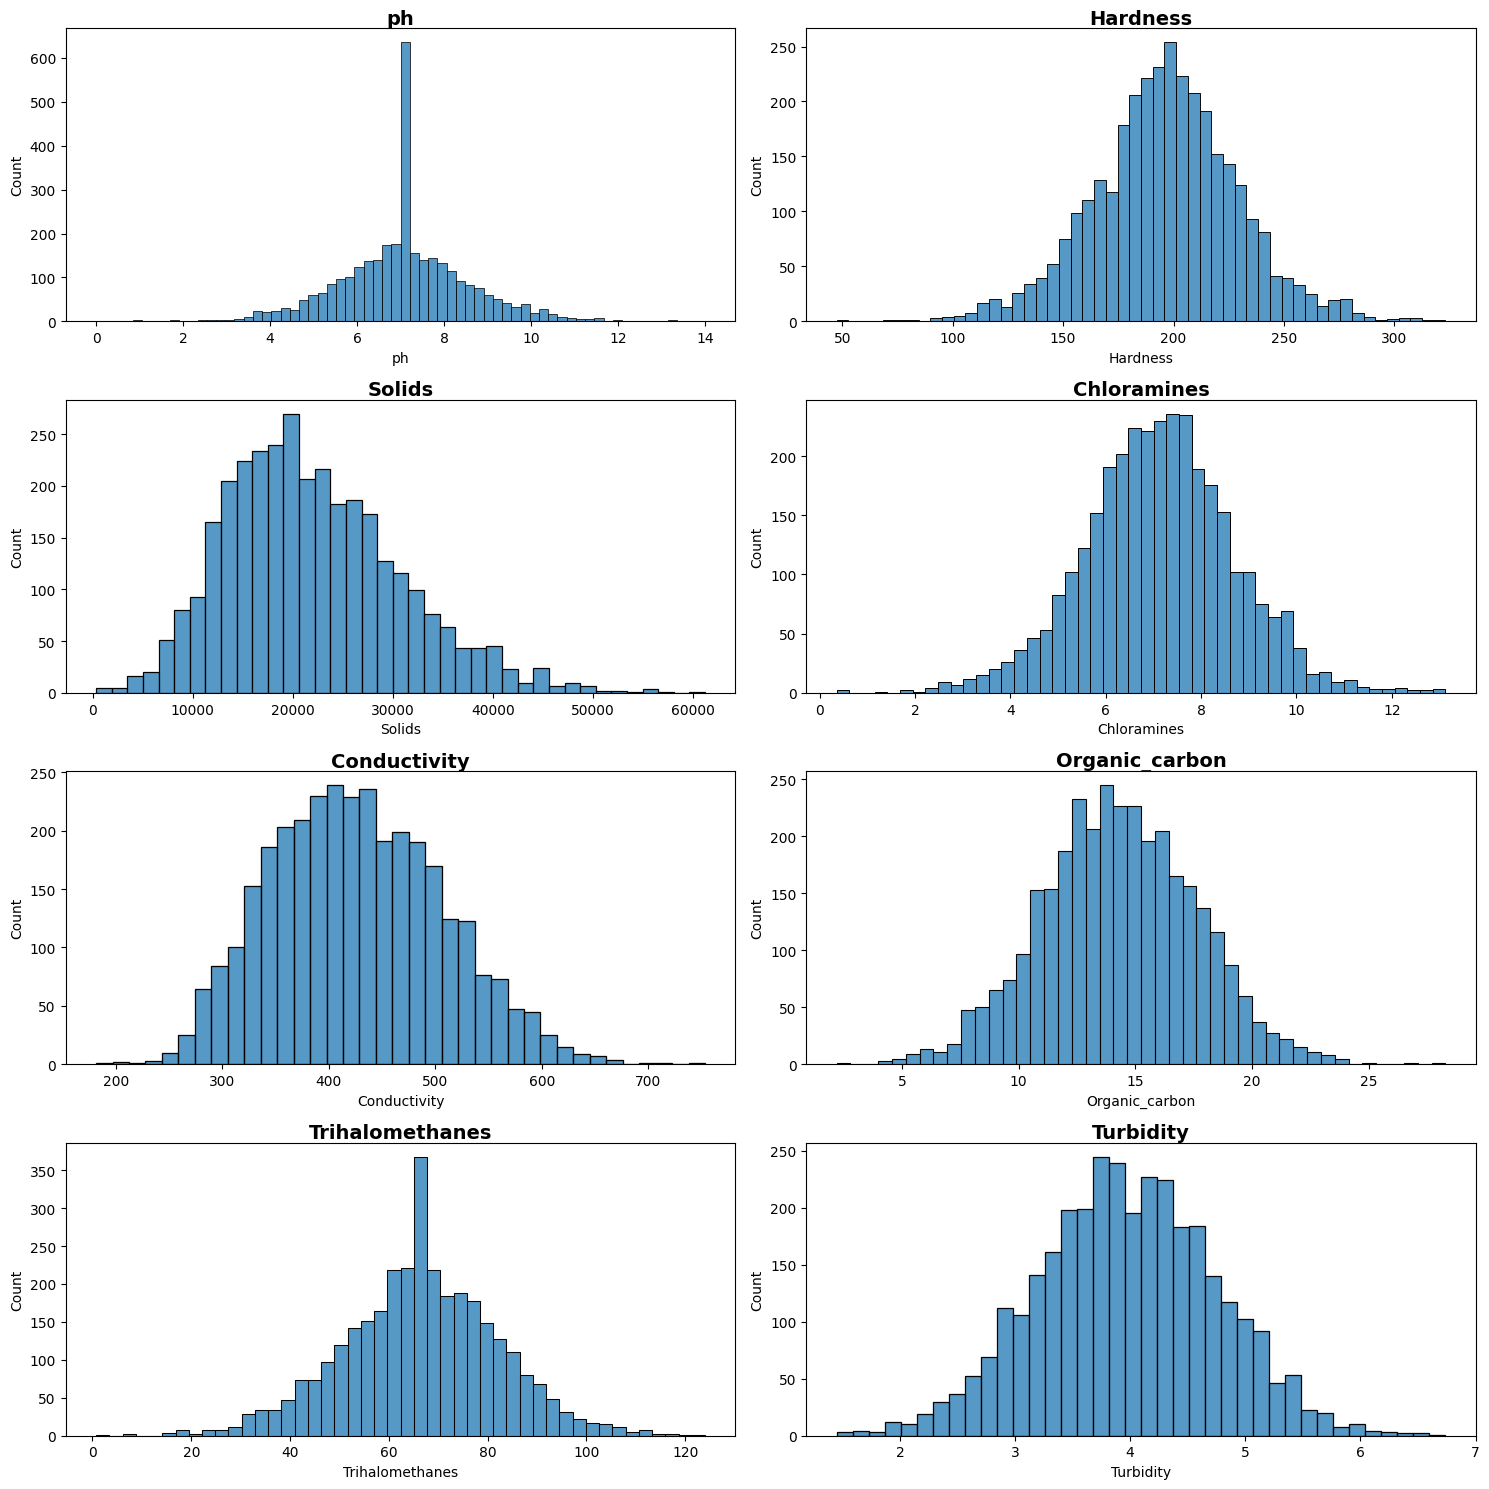

In [88]:
# Features Distribution

plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(4,2,(i%8)+1)
    sns.histplot(df[df.columns[i]])
    plt.title(df.columns[i],fontdict={'size':14,'weight':'bold'},pad=3)
plt.tight_layout()
plt.show()


In [89]:
df.select_dtypes(include="number").head(10)

,ph,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.085378,204.890455,20791.318981,7.300212,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,474.607645,12.363817,62.798309,4.401425,0
8,7.085378,118.988579,14285.583854,7.804174,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,563.885481,17.927806,71.976601,4.370562,0


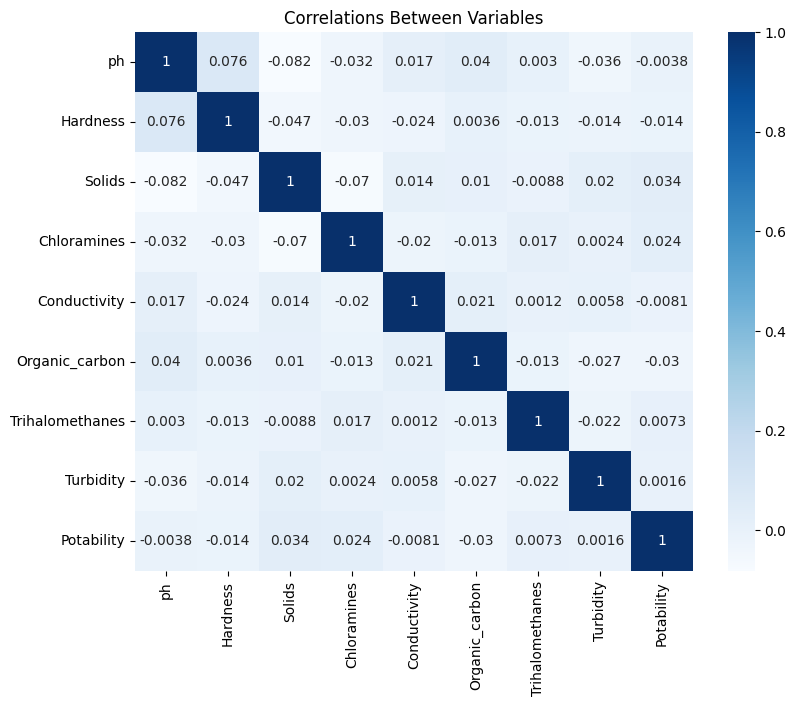

In [90]:
"""
Visualizing the linear correlations between variables using Heatmap Visualization. 
The measure used for finding the linear correlation between each variable is Pearson Correlation Coefficient.
"""

plt.figure(figsize=(9,7))
sns.heatmap(df.select_dtypes(include="number").corr(), annot=True, cmap="Blues")
plt.title("Correlations Between Variables", size=12)
plt.show()

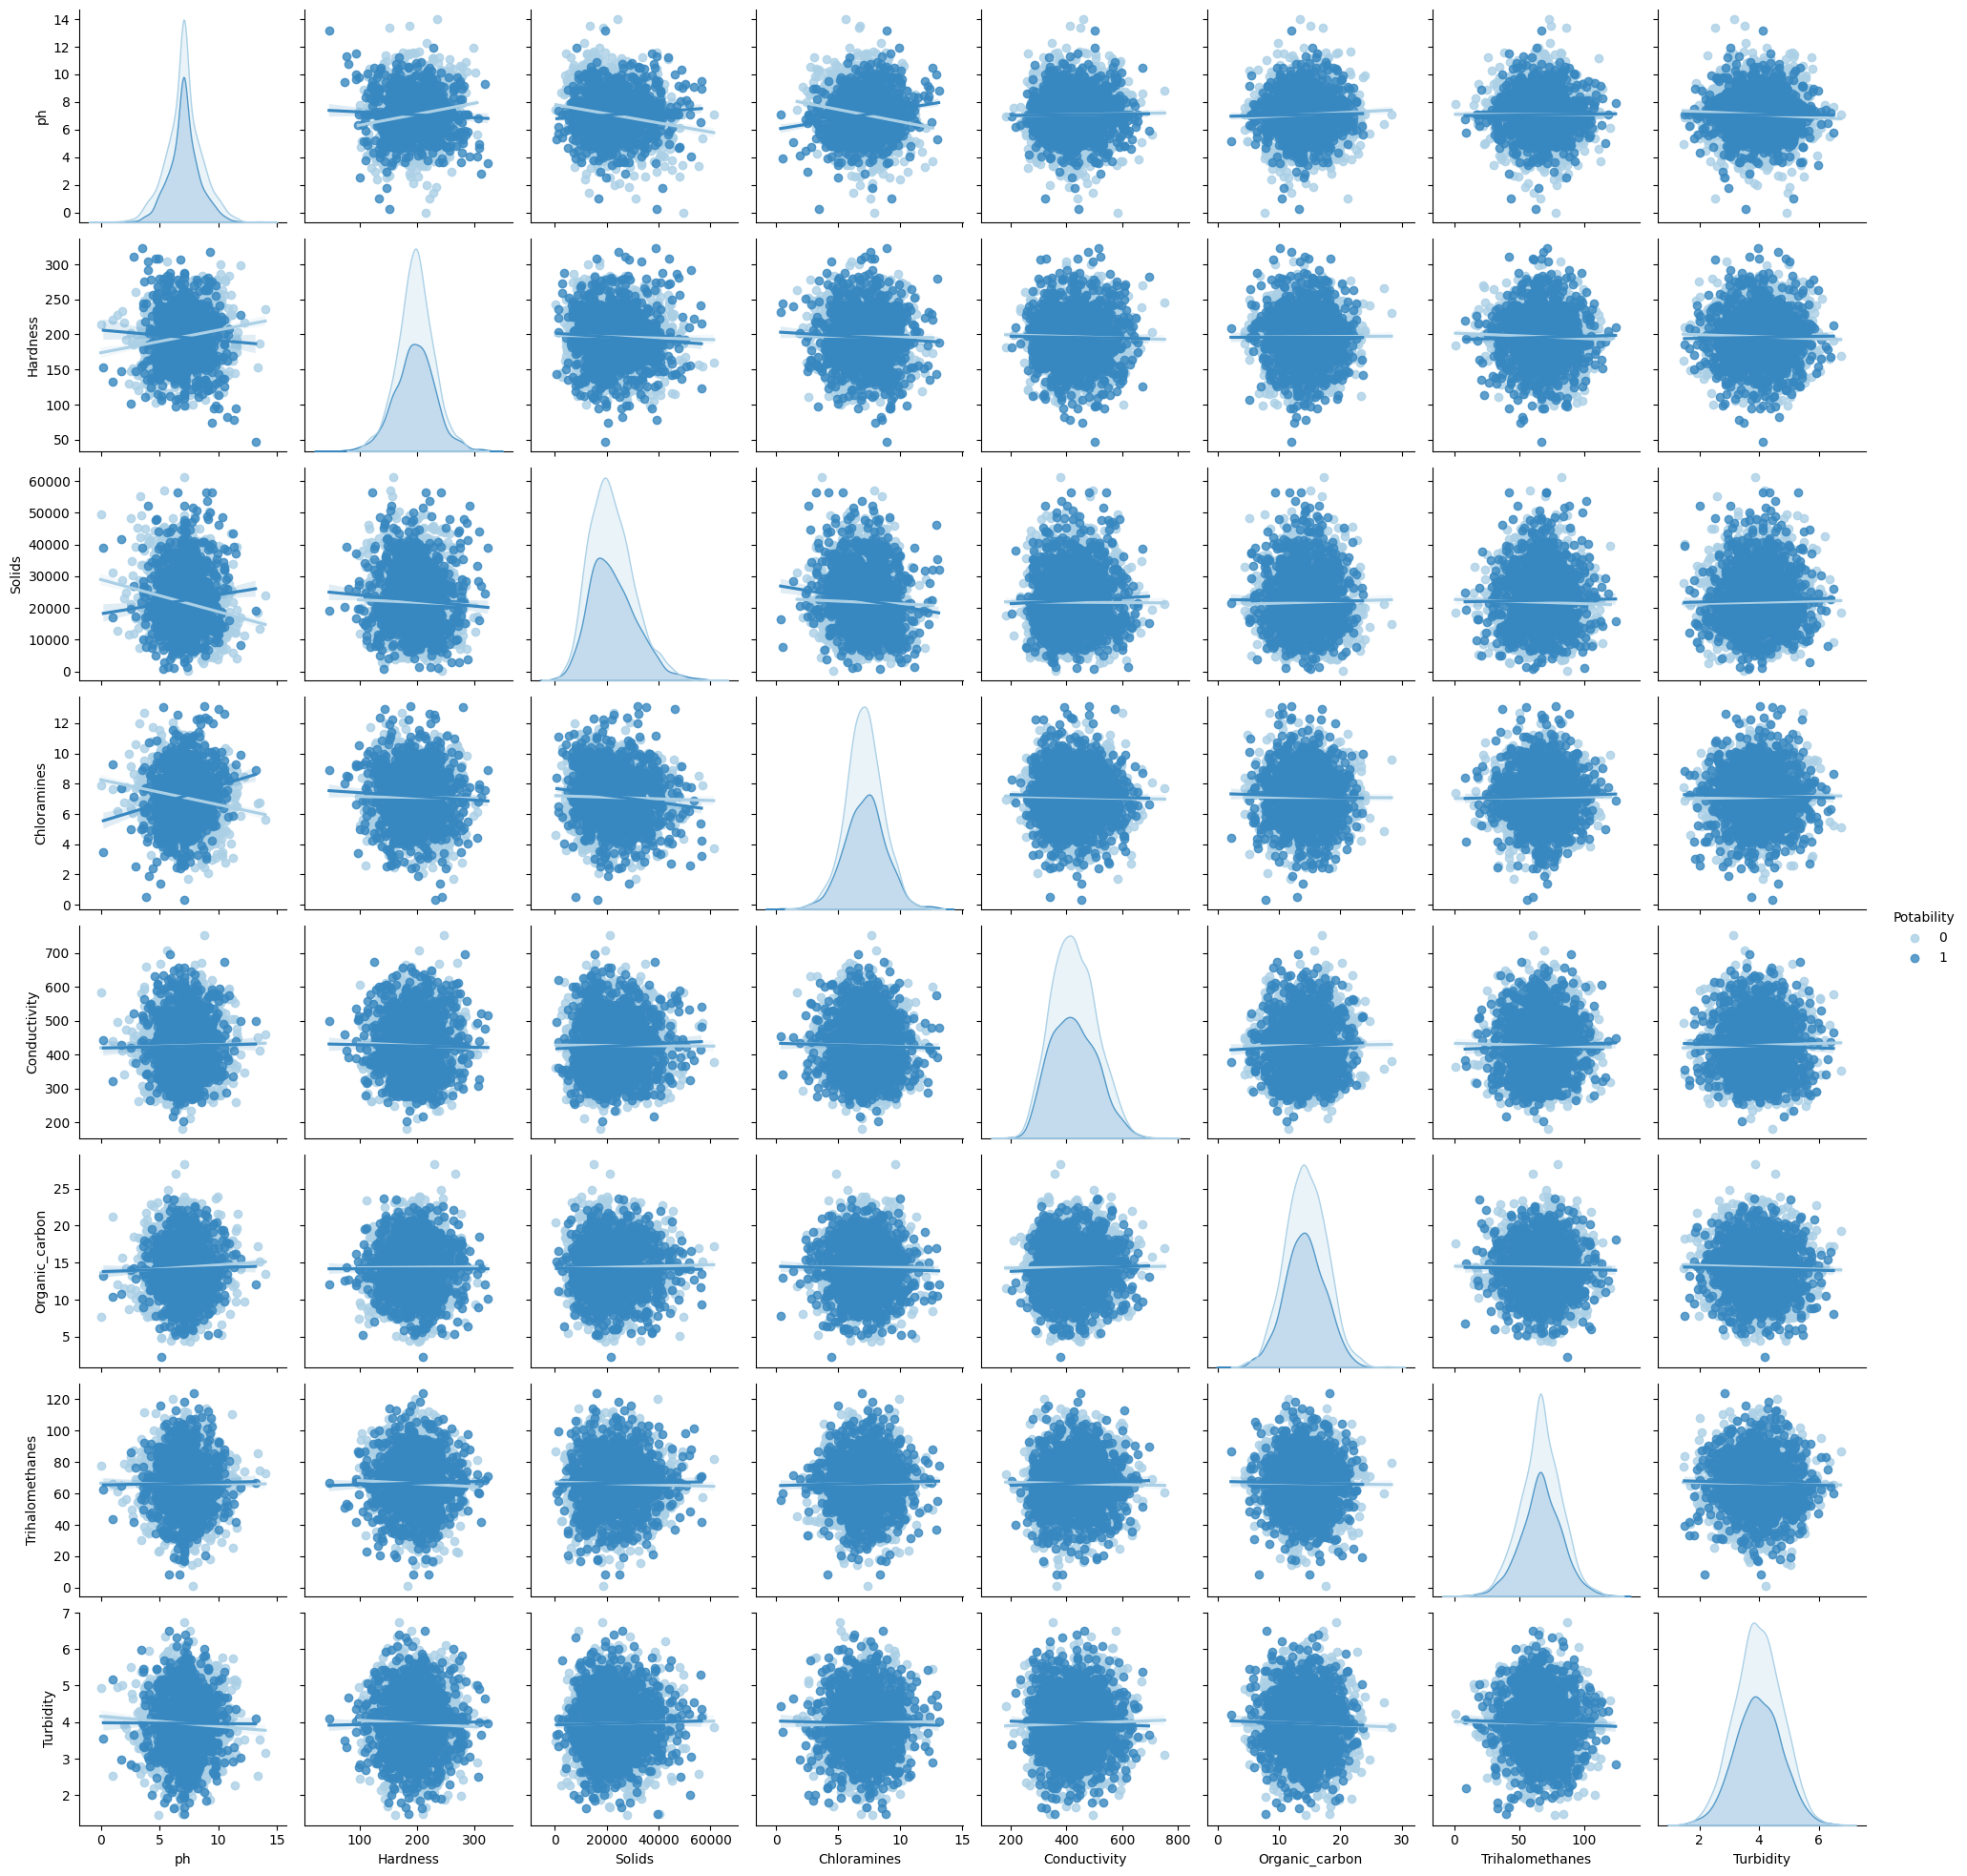

In [91]:
sns.pairplot(df, hue='Potability', kind='reg', palette='Blues')
plt.show()

In [94]:
#One Hot Encoding of Categorical Columns
data = pd.get_dummies(df, columns = ['Type of Water', 'Type of Hardness'])
data.head()

,ph,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,Type of Water_Acidic water,Type of Water_Alkaline water,Type of Water_Bottled waters labeled as alkaline,Type of Water_Common bottled waters,Type of Water_Distilled reverse osmosis water,Type of Water_Ocean water,Type of Hardness_Hard,Type of Hardness_Moderately hard,Type of Hardness_Slightly hard,Type of Hardness_Very Hard
0,7.085378,204.890455,20791.318981,7.300212,564.308654,10.379783,86.990970,2.963135,0,0,0,0,1,0,0,0,0,0,1
1,3.716080,129.422921,18630.057858,6.635246,592.885359,15.180013,56.329076,4.500656,0,1,0,0,0,0,0,1,0,0,0
2,8.099124,224.236259,19909.541732,9.275884,418.606213,16.868637,66.420093,3.055934,0,0,0,1,0,0,0,0,0,0,1
3,8.316766,214.373394,22018.417441,8.059332,363.266516,18.436524,100.341674,4.628771,0,0,0,1,0,0,0,0,0,0,1
4,9.092223,181.101509,17978.986339,6.546600,398.410813,11.558279,31.997993,4.075075,0,0,1,0,0,0,0,0,0,0,1


In [95]:
# Separate into X and y variables
X = data.drop(['Potability'], axis = 1)
Y = data['Potability']

In [96]:
#Split the dataset
# 80% training and 20% test dataset
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=83)

In [97]:
#Standardizing The Data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [ ]:
#Modelling

In [98]:
#Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
logreg_acc = round(accuracy_score(y_test, y_pred), 2)
logreg_acc

0.64

Logistic Regression

              precision    recall  f1-score   support

           0       0.68      0.94      0.78       422
           1       0.62      0.19      0.29       234

    accuracy                           0.67       656
   macro avg       0.65      0.56      0.54       656
weighted avg       0.66      0.67      0.61       656



<Axes: >

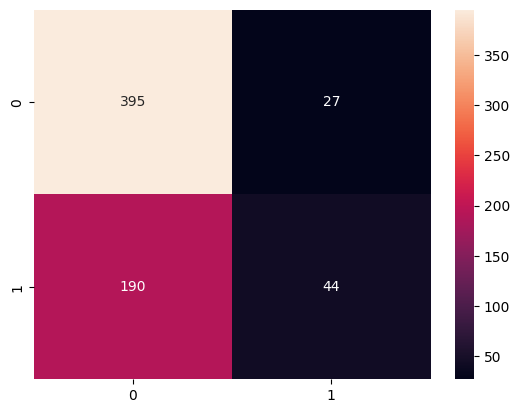

In [105]:
print('Logistic Regression\n')
log_cm = confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
sns.heatmap(log_cm, annot = True, fmt='d')

In [122]:
#Support Vector Classifier
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
svc_acc = round(accuracy_score(y_test, y_pred), 2)
svc_acc

0.67

Support Vector Classifier

              precision    recall  f1-score   support

           0       0.68      0.94      0.78       422
           1       0.62      0.19      0.29       234

    accuracy                           0.67       656
   macro avg       0.65      0.56      0.54       656
weighted avg       0.66      0.67      0.61       656



<Axes: >

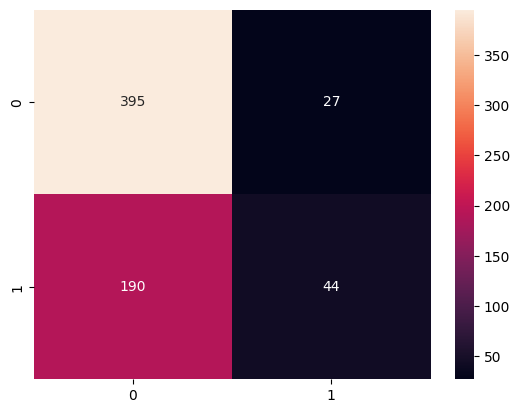

In [123]:
print('Support Vector Classifier\n')
svc_cm = confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
sns.heatmap(svc_cm, annot = True, fmt='d')

In [124]:
#KNeighbors Classifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
knn_acc = round(accuracy_score(y_test, y_pred), 2)
knn_acc

0.58

KNeighbors Classifier

              precision    recall  f1-score   support

           0       0.67      0.68      0.67       422
           1       0.41      0.40      0.40       234

    accuracy                           0.58       656
   macro avg       0.54      0.54      0.54       656
weighted avg       0.58      0.58      0.58       656



<Axes: >

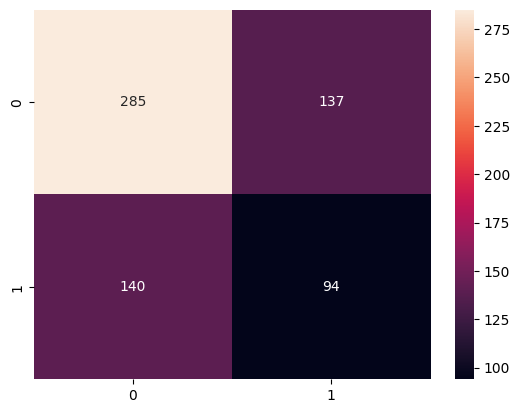

In [125]:
print('KNeighbors Classifier\n')
knn_cm = confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
sns.heatmap(knn_cm, annot = True, fmt='d')

In [126]:
#GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)

y_pred = gaussian.predict(X_test)
gaussian_acc = round(accuracy_score(y_test, y_pred), 2)
gaussian_acc

0.36

GaussianNB

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       422
           1       0.36      1.00      0.53       234

    accuracy                           0.36       656
   macro avg       0.18      0.50      0.26       656
weighted avg       0.13      0.36      0.19       656



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<Axes: >

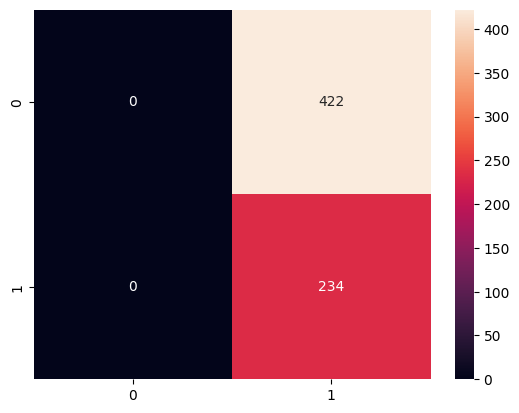

In [127]:
print('GaussianNB\n')
gaussian_cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
sns.heatmap(gaussian_cm, annot = True, fmt='d')

In [134]:
#Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
decision_tree_acc = round(accuracy_score(y_test, y_pred), 2)
decision_tree_acc

0.55

Decision Tree

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       422
           1       0.38      0.43      0.40       234

    accuracy                           0.55       656
   macro avg       0.52      0.52      0.52       656
weighted avg       0.56      0.55      0.56       656



<Axes: >

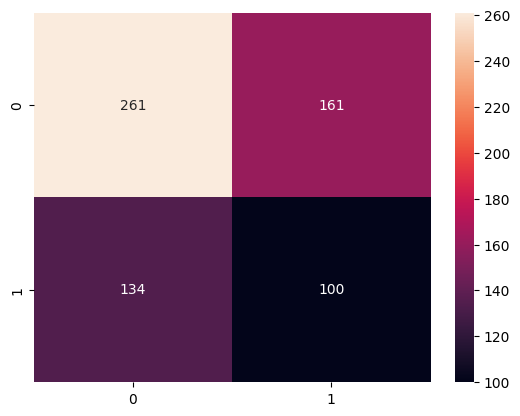

In [135]:
print('Decision Tree\n')
decision_tree_cm = confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
sns.heatmap(decision_tree_cm, annot = True, fmt='d')

In [136]:
#Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)
random_forest_acc = round(accuracy_score(y_test, y_pred), 2)
random_forest_acc

0.55

Random Forest

              precision    recall  f1-score   support

           0       0.65      0.66      0.65       422
           1       0.37      0.36      0.37       234

    accuracy                           0.55       656
   macro avg       0.51      0.51      0.51       656
weighted avg       0.55      0.55      0.55       656



<Axes: >

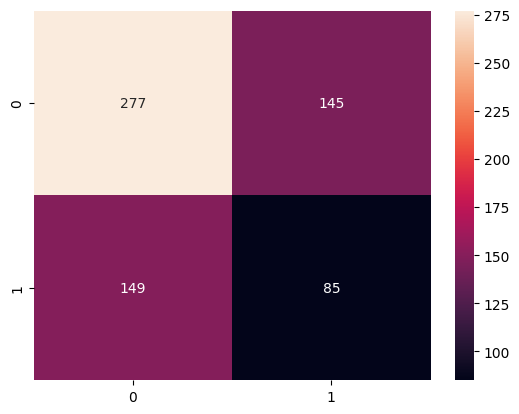

In [137]:
print('Random Forest\n')
random_forest_cm = confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
sns.heatmap(random_forest_cm, annot = True, fmt='d')

In [138]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes',
              'Decision Tree'],
    'Accuracy_score': [svc_acc, knn_acc, logreg_acc, 
              random_forest_acc, gaussian_acc, decision_tree_acc]})
models.sort_values(by='Accuracy_score', ascending=False)

,Model,Accuracy_score
0,Support Vector Machines,0.67
2,Logistic Regression,0.64
1,KNN,0.58
3,Random Forest,0.55
5,Decision Tree,0.55
4,Naive Bayes,0.36


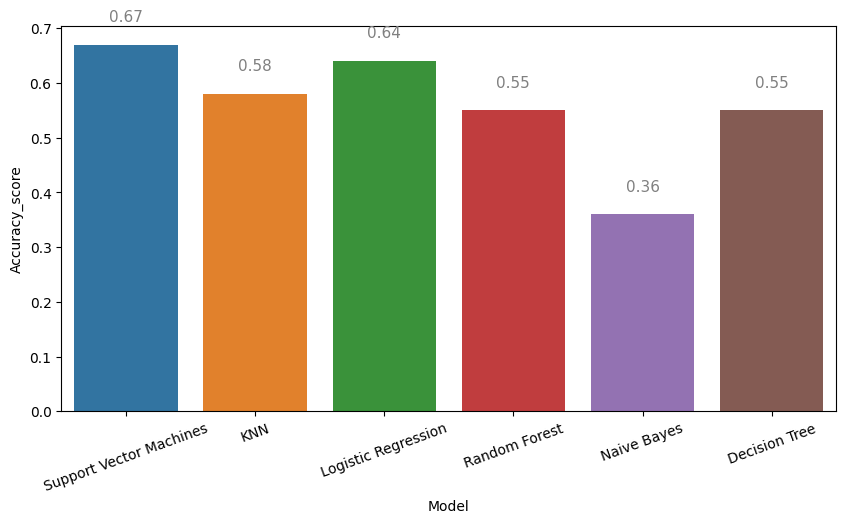

In [148]:
plt.figure(figsize=(10,5))
sns.barplot(x='Model', y='Accuracy_score', data=models)
plt.xticks(rotation=20)

ax = plt.gca()
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                textcoords='offset points')

plt.show()